In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pprint import pprint
from glob import glob
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Input, Lambda, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from itertools import repeat
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid
import re
from scripts.constants import SEED
from pprint import pprint
import tensorflow_probability as tfp

In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'B2': tf.io.FixedLenFeature([256, 256], dtype=tf.float32),  # B
        'B3': tf.io.FixedLenFeature([256, 256], dtype=tf.float32),  # G
        'B4': tf.io.FixedLenFeature([256, 256], dtype=tf.float32),  # R
        #'AVE': tf.io.FixedLenFeature([256, 256], dtype=tf.float32), # Elevation
        #'NDWI': tf.io.FixedLenFeature([256, 256], dtype=tf.float32), # vegetation index
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)

In [46]:
def predict_input_fn(fileNames,side,bands):
  
    # Read `TFRecordDatasets` 
    dataset = tf.data.TFRecordDataset(fileNames, compression_type='GZIP')

    featuresDict = {x:tf.io.FixedLenFeature([side, side], dtype=tf.float32) for x in bands}

    # Make a parsing function
    def parse_image(example_proto):
        parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
        return parsed_features
  
    def stack_images(features):         
        nfeat = tf.transpose(tf.squeeze(tf.stack(list(features.values()))))    
        return nfeat
 
    dataset = dataset.map(parse_image, num_parallel_calls=4)
    dataset = dataset.map(stack_images, num_parallel_calls=4)   
    dataset = dataset.batch(side*side)

    return dataset

In [5]:
dataset = predict_input_fn('canama/Predict_CamanaValleyCrop-00000.tfrecord.gz', 256, ['R', 'G', 'B'])

for x in dataset:
    print(x.shape)

(2, 256, 256, 3)


datamat shape (256, 256)
i 0
j 0
datamat shape (256, 256)
i 1
j 0
datamat shape (256, 256)
i 0
j 0
datamat shape (256, 256)
i 1
j 0
datamat shape (256, 256)
i 0
j 0
datamat shape (256, 256)
i 1
j 0
1.0


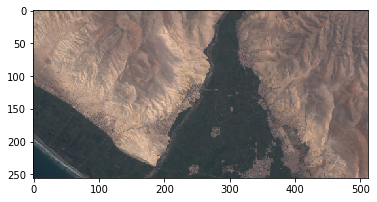

In [6]:
data = iter(dataset)
data = next(data)

def stretch_image_colorspace(img):
    max_val = np.max(img)
    return img / max_val


fullData = np.zeros([256*2, 256*1, 3])
for n in range(0,3):
    dataMat = np.zeros([256*2, 256*1])
    z = 0
    for j in range(0,1):
        for i in range(0,2):
            #print("datamat shape", dataMat[i*256: (i+1)*256, j*256: (j+1)*256 ].shape)
            #print("i", i)
            #print("j", j)
            dataMat[i*256: (i+1)*256, j*256: (j+1)*256 ] = np.squeeze(data[z, :, :, n])
            z += 1
    fullData[:,:,n] = dataMat

fullData = stretch_image_colorspace(fullData)
fullData = np.transpose(np.array([fullData[:,:,2], fullData[:,:,1], fullData[:,:,0]]), (1, 2 ,0 ))
plt.imshow(np.fliplr(np.rot90(fullData, k=3)))
print(np.max(fullData))
   

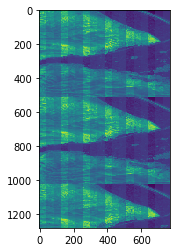

In [7]:
dataMat = np.resize(data, (256*5, 256*3))
plt.imshow(dataMat)

In [56]:
files = sorted(glob('testlocations/*.tfrecord.gz'))
print(files)
images = []

for x in files:
    dataset = predict_input_fn(x, 256, ['R', 'G', 'B'])
    images.append(dataset)

    
for x in images:
    print(next(iter(x)).shape)
    

['testlocations/testLoc0-00000.tfrecord.gz', 'testlocations/testLoc1-00000.tfrecord.gz', 'testlocations/testLoc2-00000.tfrecord.gz', 'testlocations/testLoc3-00000.tfrecord.gz', 'testlocations/testLoc4-00000.tfrecord.gz']
(81, 256, 256, 3)
(81, 256, 256, 3)
(81, 256, 256, 3)
(100, 256, 256, 3)
(64, 256, 256, 3)


1.0


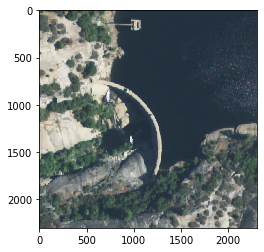

In [58]:
data = images[0]
data = next(iter(data))

def stretch_image_colorspace(img):
    max_val = np.max(img)
    return img / max_val

# patch per row
pp_row = 9
rows = 9 
def stitch_patches(data, patch_size, n_cols, n_rows ):

    fullData = np.zeros([patch_size*n_cols, patch_size*n_rows, 3])
    for n in range(0,3):
        dataMat = np.zeros([patch_size*n_cols, patch_size*n_rows])
        z = 0
        for j in range(0,n_rows):
            for i in range(0,n_cols):
                #print("datamat shape", dataMat[i*256: (i+1)*256, j*256: (j+1)*256 ].shape)
                #print("i", i)
                #print("j", j)
                dataMat[i*patch_size: (i+1)*patch_size, j*patch_size: (j+1)*patch_size ] = np.squeeze(data[z, :, :, n])
                z += 1
        fullData[:,:,n] = dataMat

    fullData = stretch_image_colorspace(fullData)
    fullData = np.transpose(np.array([fullData[:,:,2], fullData[:,:,1], fullData[:,:,0]]), (1, 2 ,0 ))
    return fullData

full_image = stitch_patches(data,256, 9, 9)

plt.imshow(np.fliplr(np.rot90(full_image, k=3)))
print(np.max(full_image))

0
1
2


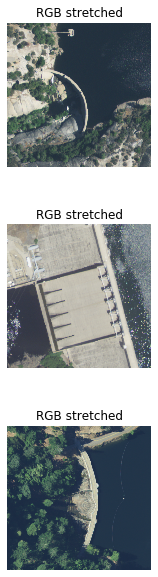

In [63]:
# ADD AVE/NDWI heatmaps?
data = iter(dataset)
columns = 1
rows = 3

fig = plt.figure(figsize=(columns+8, rows+5))
gs = gridspec.GridSpec(rows, columns,
        wspace=0.0, hspace=0.4, 
        top=1.2-0.5/(rows + 1), bottom=0.5/(rows+1), 
        left=0.5/(columns+1), right=1-0.2/(columns+1)) 

for j,x in enumerate(images[0:3]):
    img_features = next(iter(x))
    full_image = stitch_patches(img_features,256, 9, 9)

    print(j)
    #good example: stretched colorspace
    #uint8 only stores 256 values :/
    ax = plt.subplot(gs[j,0])
    ax.set_title("RGB stretched")
    ax.imshow(np.fliplr(np.rot90(full_image, k=3)))
    plt.axis('off')


In [64]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Sep 27 14:05:17 2019

@author: stephan
"""
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Input
from tensorflow.keras.models import Model



# TODO: target size with variable channels
# TODO: variable number of classes

# TEMPORARY MODEL FOR TESTING PURPOSES ONLY


def build_dilated_fcn_61(train_model = True, **kwargs): 
    ## DEFINE THE ABOVE DESCRIBED MODEL HERE
    x_in = Input(batch_shape=(None, None, None, 3 ))
    x = Conv2D(filters=32,kernel_size=(7,7),activation='relu')(x_in) # 55, 55
    x = Conv2D(filters=32,kernel_size=(7,7), dilation_rate = 2, activation='relu')(x) # 43, 43
    x = Conv2D(filters=32,kernel_size=(5,5), activation='relu')(x) # 37, 37
    x = Conv2D(filters=32,kernel_size=(5,5), dilation_rate = 2, activation='relu')(x) # 31, 31
    x = Conv2D(filters=64,kernel_size=(5,5), activation='relu')(x) # 27, 27
    x = Conv2D(filters=64,kernel_size=(5,5), dilation_rate = 2, activation='relu')(x) # 19, 19
    x = Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x) # 17, 17
    x = Conv2D(filters=64,kernel_size=(3,3), dilation_rate = 2, activation='relu')(x) # 13, 13
    x = Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x) # 11, 11
    x = Conv2D(filters=64,kernel_size=(3,3), dilation_rate = 2, activation='relu')(x) # 7, 7
    x = Conv2D(filters=128,kernel_size=(3,3), activation='relu')(x) # 5, 5
    x = Conv2D(filters=128,kernel_size=(3,3), activation='relu')(x) # 3, 3
    x = Conv2D(filters=64,kernel_size=(3,3), activation='relu')(x) # 1, 1
    x = Conv2D(filters=64,kernel_size=(1,1), activation='relu')(x)
    x_out = Conv2D(filters=2,kernel_size=(1,1),activation='softmax')(x)
    if train_model:
        x_out = Flatten()(x_out)
    model = Model(inputs = x_in, outputs=x_out)

    model.summary()
    return model

In [77]:
x = build_dilated_fcn_61(train_model=False)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, None, 32)    4736      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, None, None, 32)    50208     
_________________________________________________________________
conv2d_32 (Conv2D)           (None, None, None, 32)    25632     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, None, None, 32)    25632     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, None, None, 64)    51264     
_________________________________________________________________
conv2d_35 (Conv2D)           (None, None, None, 64)    1024

In [78]:
x.load_weights('checkpoints/model-dilated_fcn-2019_10_29_16_36_24.hdf5')

In [106]:
test = full_image[np.newaxis,0:1000,0:1000,:] 
preds = x.predict(test)
test1 = full_image[np.newaxis,0:1000, 1000:2000, :] 
preds1 = x.predict(test1)
test2 = full_image[np.newaxis,1000:2000, 0:1000, :] 
preds2 = x.predict(test2)
test3 = full_image[np.newaxis,1000:2000, 1000:2000, :] 
preds3 = x.predict(test3)

print(preds.shape, preds1.shape, preds2.shape, preds3.shape)

row1preds = np.append(preds[0,:,:,1], preds1[0,:,:,1], axis=1)
row2preds = np.append(preds2[0,:,:,1], preds3[0,:,:,1], axis=1)
allpreds= np.append(row1preds, row2preds, axis=0)
print(allpreds.shape)

(1, 940, 940, 2) (1, 940, 940, 2) (1, 940, 940, 2) (1, 940, 940, 2)
(1880, 1880)


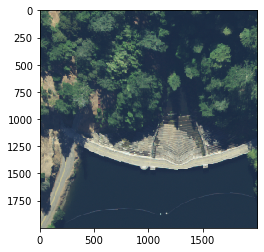

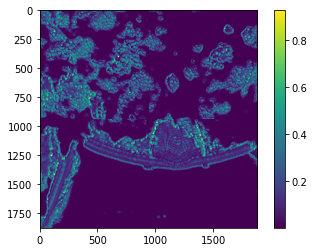

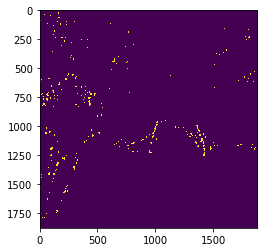

In [108]:
plt.figure()
plt.imshow(full_image[0:2000, 0:2000, :])
plt.figure()
plt.imshow(allpreds, 
           cmap='viridis', 
           interpolation='nearest')
plt.colorbar()

mask = allpreds > 0.5

plt.figure()
plt.imshow(mask, 
           interpolation='nearest')
